# Forecasting Bitcoin Prices with Time Series Analysis

## Introduction

Time series forecasting plays a critical role in financial markets, as it helps predict future price movements and trends based on historical data. In the volatile world of cryptocurrencies, particularly Bitcoin, accurate forecasting is essential for making informed investment decisions, managing risk, and identifying potential market opportunities. Due to its decentralized nature and high price fluctuations, Bitcoin is influenced by a variety of factors such as market sentiment, technological developments, and macroeconomic conditions. Effective time series models allow traders and analysts to anticipate price movements, helping to optimize strategies in this fast-paced market.

In this notebook, we will:
- Acquire and preprocess historical Bitcoin price data.
- Explore and visualize the data.
- Build and train an LSTM model for price prediction.
- Evaluate the model's performance.
- Discuss the findings and insights.


## 1. Getting the Data

Download Bitcoin historical data from GitHub

In [42]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-09-20 19:05:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.005s  

2024-09-20 19:05:08 (35.6 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



### Importing Necessary modules

In [41]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


### Reading the data

In [46]:
# Load the dataset
df = pd.read_csv(
    "/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
    parse_dates=True,
    index_col=["Date"]
)

# Display the first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Display the last few rows
print("\nLast 5 rows of the dataset:")
display(df.tail())

# Display dataset information
print("\nDataset Information:")
df.info()

# Check the length of the dataset
print(f"\nTotal number of entries: {len(df)}")


First 5 rows of the dataset:


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566



Last 5 rows of the dataset:


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB

Total number of entries: 2787


## Extract the 'Closing Price (USD)' and rename it to 'price'


The reason for extracting the 'Closing Price (USD)' and renaming it to 'price' in a time series forecasting context, particularly with Bitcoin or any financial asset, is primarily for convenience and clarity:

1. **Key Metric for Analysis**: The closing price is one of the most critical metrics in financial markets, as it represents the final price at which an asset was traded during a trading session. It's often used for trend analysis and forecasting.

2. **Simplification for Code Readability**: Renaming the column to 'price' makes it easier to reference and improves readability in the code. It simplifies the handling of data, especially if the analysis involves multiple columns with long names or complex operations.

3. **Consistency Across Models**: When building models, using generic and consistent naming (like 'price') ensures compatibility and reduces confusion when experimenting with different assets or data sources.

In summary, this step helps prepare the data for analysis by focusing on the most relevant feature (closing price) and making the dataset easier to manage.

In [47]:
# Extract the 'Closing Price (USD)' and rename it to 'price'
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "price"})

# Display the first few rows
print("Bitcoin Prices:")
bitcoin_prices.head()


Bitcoin Prices:


,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


## Data Visualization

### Plotting the Bitcoin price over time

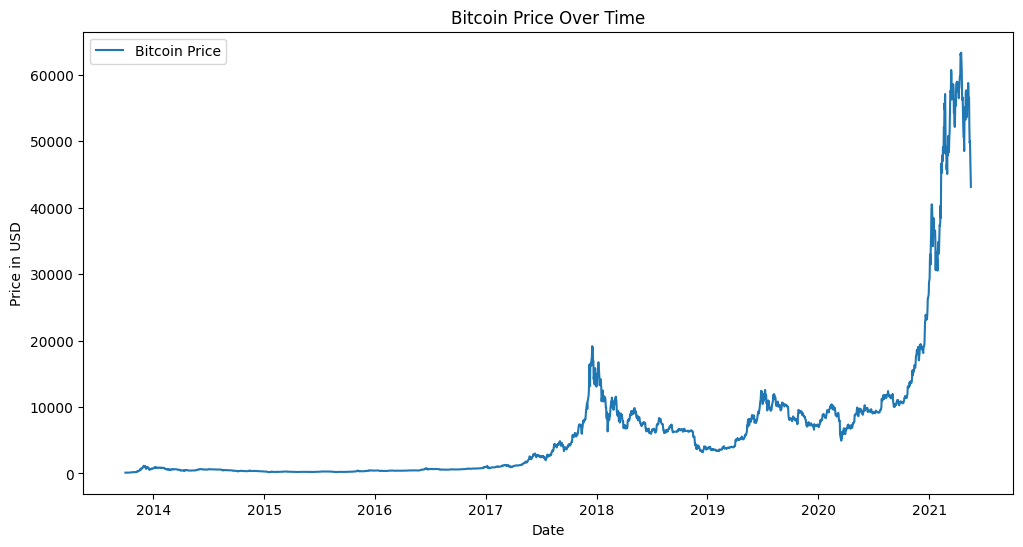

In [48]:
# Plotting the Bitcoin price over time
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_prices, label="Bitcoin Price")
plt.ylabel("Price in USD")
plt.xlabel("Date")
plt.title("Bitcoin Price Over Time")
plt.legend()
plt.show()

# 2-  Preprocessing Method:

### Important Note on Time Series Data Splitting:

*When working with **time series data**, it’s essential to remember that splitting the data goes beyond the typical 80/20 train-test split. Time series models must account for the sequential nature of the data. Unlike random splits in regular datasets, time series forecasting relies on the **chronological order** of the data.*






1. **Extraction of Target Feature (Closing Price)**:
   - The **closing price** is a critical metric in financial analysis as it represents the last price traded for an asset during a given day. This price is widely used for forecasting since it reflects market sentiment at the close of each trading session.
   - Renaming it to **price** simplifies the code, making it easier to reference in further steps without confusion or verbosity.

2. **Splitting the Data (80% Training, 20% Testing)**:
   - Splitting the data based on time ensures that the model is trained on past data and tested on future data, simulating real-world scenarios where predictions are made for unseen future prices.
   - An 80/20 split is a standard approach in time series forecasting, allowing the model to have sufficient data to learn while reserving a reasonable portion for unbiased evaluation.

3. **Normalization using MinMaxScaler**:
   - **Normalization** was applied to scale the Bitcoin prices between 0 and 1. Neural networks, especially LSTM models, are sensitive to the scale of input data, and normalizing the data helps the model converge faster and improve performance.
   - **MinMaxScaler** is particularly useful in time series forecasting when the data has clear upper and lower bounds, ensuring that all values fall within a common range, reducing the risk of the model being biased by large values.

4. **Sequence Length of 60 Timesteps**:
   - A sequence length of **60 timesteps** was chosen based on typical financial analysis, where 60 days (about 2 months) of past prices offer a reasonable window to capture trends and seasonality in Bitcoin prices.
   - LSTM models are designed to capture temporal dependencies, and by feeding the model a window of 60 days, it can learn meaningful patterns from historical data that may influence future price predictions.

5. **Handling Target Prices**:
   - For each sequence of 60 days, the model was tasked with predicting the **next day's price**. This approach helps capture short-term price movements while maintaining the sequential nature of the data.
   - The next-day prediction aligns with common forecasting practices in finance, where near-future price movements are of high interest to traders and investors.

In summary, these preprocessing techniques were chosen to ensure the model performs well in capturing the underlying patterns in Bitcoin prices, handles the data efficiently, and delivers accurate predictions.


In [49]:
# Extract timesteps and prices as numpy arrays
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["price"].to_numpy()

In [50]:
# Define the split size (80% training, 20% testing)
split_size = int(len(prices) * 0.8)

# Split the data
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]


In [51]:
print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")



Training set size: 2229
Testing set size: 558


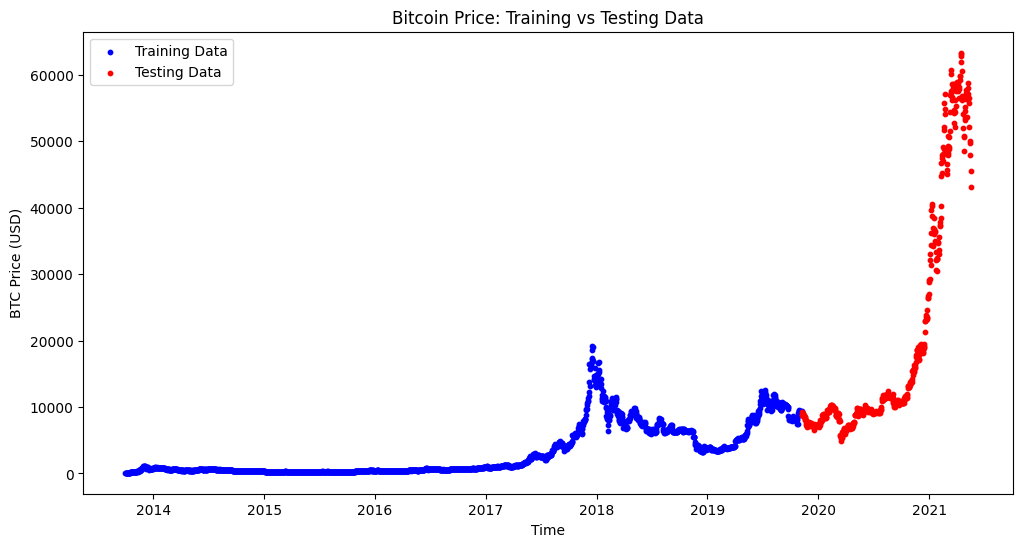

In [52]:
# Plot the training and testing data
plt.figure(figsize=(12, 6))
plt.scatter(X_train, y_train, c="blue", label="Training Data", s=10)
plt.scatter(X_test, y_test, c="red", label="Testing Data", s=10)
plt.xlabel("Time")
plt.ylabel("BTC Price (USD)")
plt.title("Bitcoin Price: Training vs Testing Data")
plt.legend()
plt.show()

In [53]:
# Define a plotting function
def plot_time_series(timesteps, values, format="-", start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price (USD)")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

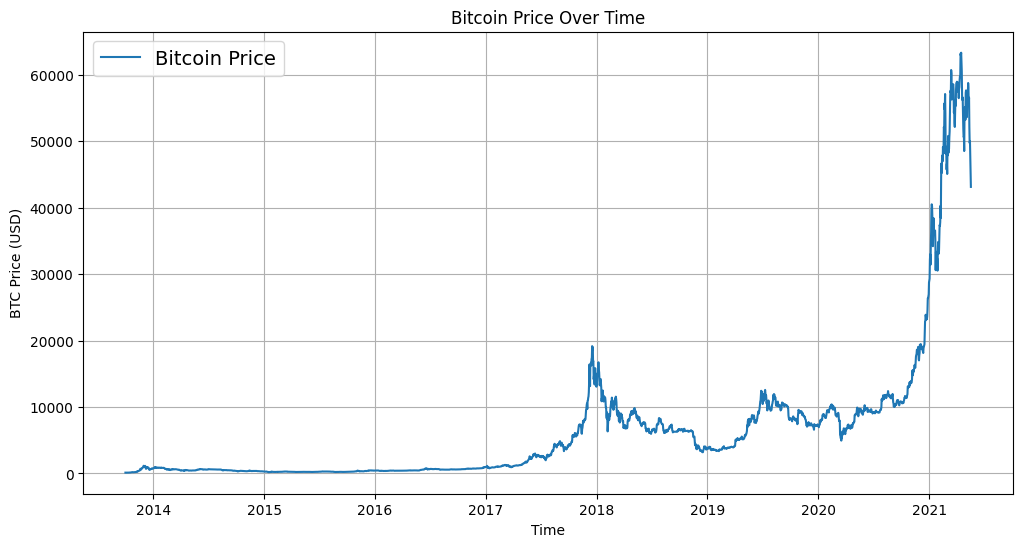

In [55]:
# Plot the entire time series
plt.figure(figsize=(12, 6))
plot_time_series(timesteps, prices, label="Bitcoin Price")
plt.title("Bitcoin Price Over Time")
plt.show()


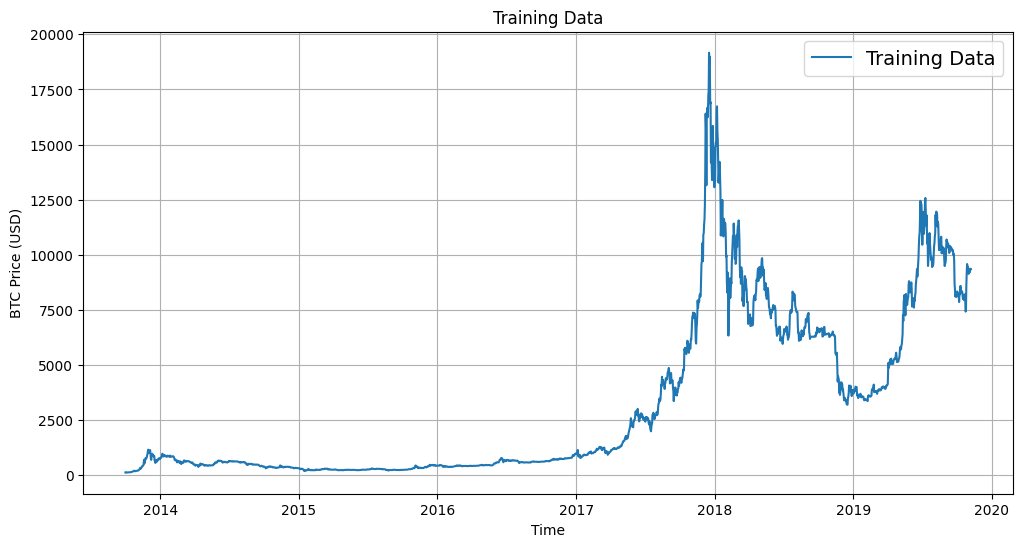

In [56]:
# Plot only the training data
plt.figure(figsize=(12, 6))
plot_time_series(X_train, y_train, label="Training Data")
plt.title("Training Data")
plt.show()

In [57]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the training data
btc_scaled = scaler.fit_transform(prices.reshape(-1, 1))


In [58]:
# Display the first 5 scaled prices
print("\nFirst 5 scaled prices:")
print(btc_scaled[:5])


First 5 scaled prices:
[[0.00023831]
 [0.00026677]
 [0.        ]
 [0.00015955]
 [0.00020168]]


In [59]:
# Define a function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [60]:

# Define the sequence length (e.g., 60 timesteps)
sequence_length = 60

# Create sequences
X, y = create_sequences(btc_scaled, sequence_length)

In [61]:
# Reshape X for RNN input (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (2727, 60, 1)
Shape of y: (2727,)


## Plotting a few sequences with their targets

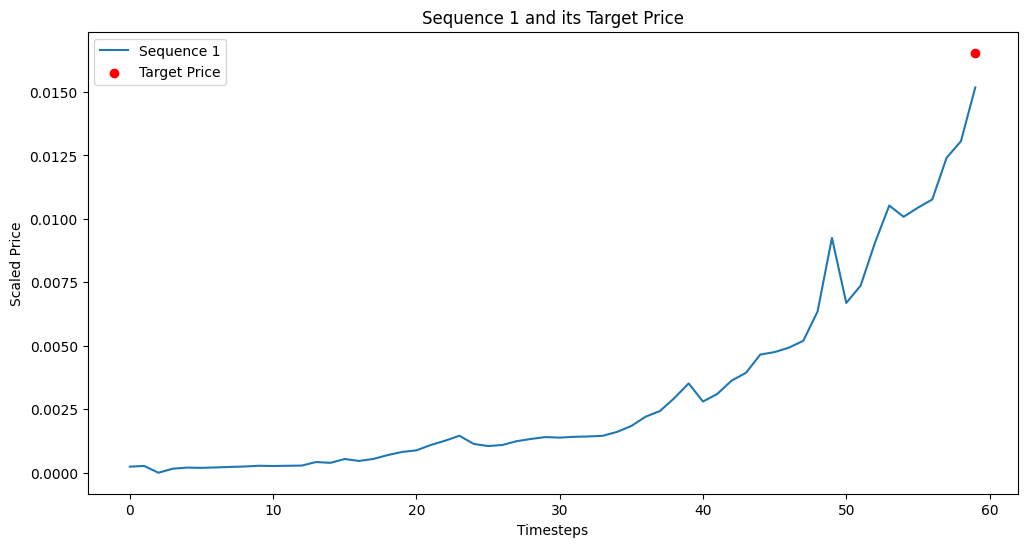

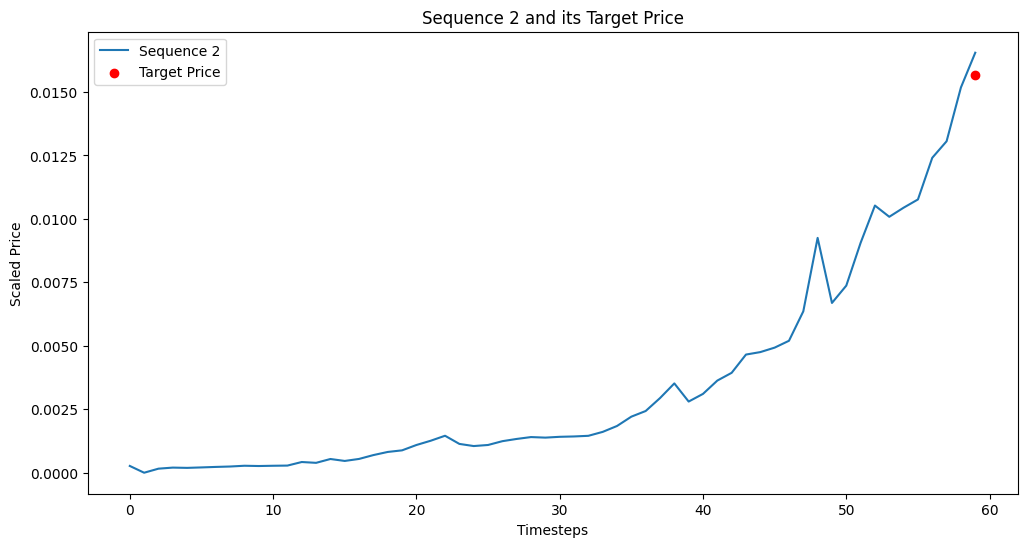

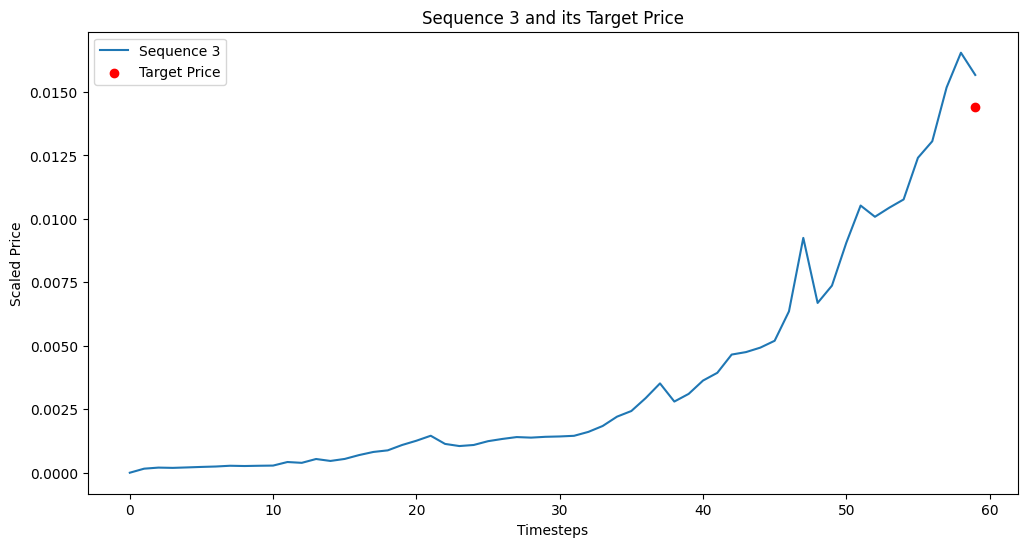

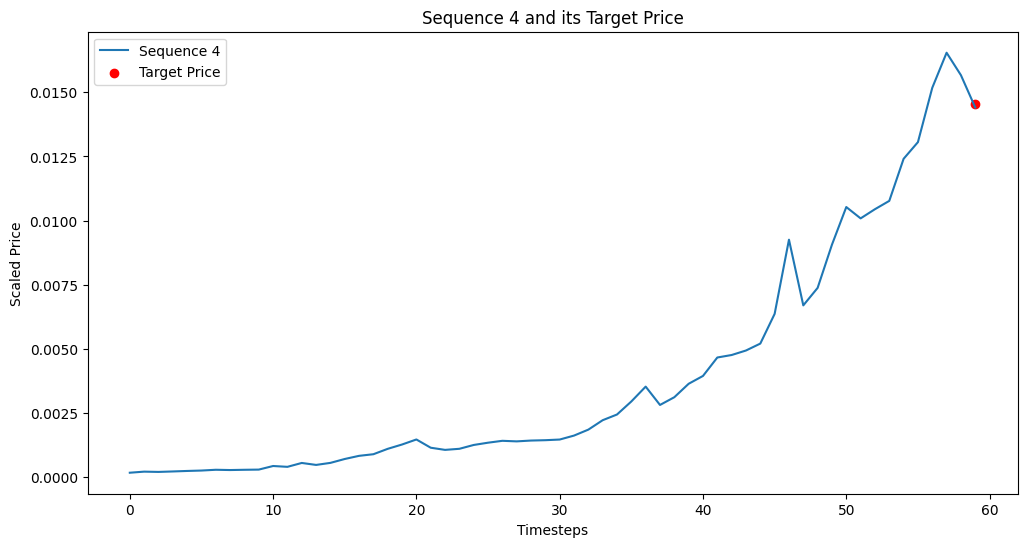

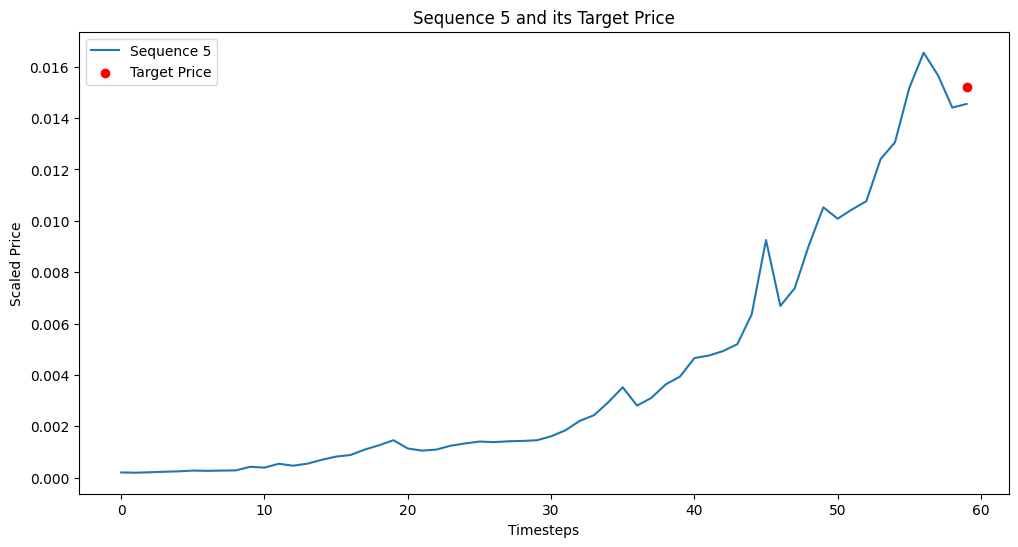

In [62]:
# Plotting the first few sequences in X and their corresponding y values
for i in range(min(5, len(X))):
  plt.figure(figsize=(12, 6))
  plt.plot(X[i], label=f"Sequence {i+1}")
  plt.scatter(len(X[i])-1, y[i], color="red", label="Target Price")
  plt.xlabel("Timesteps")
  plt.ylabel("Scaled Price")
  plt.title(f"Sequence {i+1} and its Target Price")
  plt.legend()
  plt.show()

# Setting Up tf.data.Dataset for Model Inputs

In this section, we discuss how the dataset is structured using TensorFlow's `tf.data.Dataset`, which is essential for efficiently feeding data into the model during training and evaluation.

#### Structuring the Dataset

The dataset is split into training and testing sets, and each set is converted into a `tf.data.Dataset` format. This format allows for easier manipulation of the data and improved performance during training.

### Importance of Batching, Shuffling, and Windowing

**Batching**:
- **Definition**: Batching groups multiple samples together, allowing the model to process several sequences simultaneously.
- **Importance**: This technique improves computational efficiency by leveraging parallel processing capabilities of the hardware. It also stabilizes the gradient updates during training, leading to more robust learning.

**Shuffling**:
- **Definition**: Shuffling randomly rearranges the order of the samples in the dataset.
- **Importance**: For time series data, shuffling helps prevent the model from learning any unwanted patterns based on the order of the data, such as temporal correlations that may not generalize well. While shuffling is commonly applied to non-sequential data, it can be particularly useful in the training phase to ensure a diverse representation of sequences.

**Windowing**:
- **Definition**: In time series, windowing involves creating overlapping sequences (windows) from the dataset.
- **Importance**: This approach allows the model to learn from various segments of the data, capturing different patterns and trends. It ensures that the model has access to multiple perspectives of the time series, which is crucial for accurate forecasting.


In [65]:
# Split the data into train and test sets for the model
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [80]:
# Convert the dataset into tf.data.Dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=1000)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

# Model Architecture for Forecasting

The architecture used for forecasting Bitcoin prices is a **Long Short-Term Memory (LSTM)** network, structured as follows:

1. **First LSTM Layer**:
   - **Units**: 50
   - **Return Sequences**: True
   - **Dropout**: 0.2
   - **Input Shape**: (X.shape[1], 1)
   
   This layer processes the input sequences and returns the full sequence of outputs, which allows the next LSTM layer to continue processing.

2. **Second LSTM Layer**:
   - **Units**: 50
   - **Return Sequences**: False
   - **Dropout**: 0.2
   
   This layer further captures the temporal dependencies in the data but returns only the last output, which will be passed to the dense layers.

3. **Dense Layer**:
   - **Units**: 25
   
   This layer acts as a fully connected layer to process the features extracted by the LSTM layers.

4. **Output Layer**:
   - **Units**: 1
   
   This layer outputs the final prediction, which is the forecasted price for the next time step.

### Why I chose LSTM?

- **Handling Sequential Data**: LSTMs are specifically designed to work with sequence prediction problems, making them ideal for time series forecasting. They can capture long-term dependencies, which is crucial for understanding trends and patterns in historical price data.

- **Mitigation of Vanishing Gradient Problem**: LSTMs address the vanishing gradient problem commonly encountered in traditional recurrent neural networks (RNNs). This allows for better learning across longer sequences.

- **Flexibility in Architecture**: The ability to stack multiple LSTM layers enhances the model's capacity to learn complex patterns and improve predictive performance.

- **Dropout Regularization**: Incorporating dropout layers helps prevent overfitting by randomly setting a fraction of the input units to zero during training, leading to a more generalized model.

Overall, this architecture is well-suited for the complexities of financial time series data, such as Bitcoin prices, where capturing temporal dependencies and trends is vital for accurate forecasting.


In [63]:
# Define the LSTM model
model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layer
model.add(Dense(units=25))

# Output layer
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model architecture
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Define training parameters
batch_size = 32
epochs = 50


In [92]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, verbose=1)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 1.0215e-04 - val_loss: 0.0031
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 7.6461e-05 - val_loss: 0.0054
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 1.1819e-04 - val_loss: 0.0040
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 5.8708e-05 - val_loss: 0.0015
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 7.7768e-05 - val_loss: 0.0021
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 7.4058e-05 - val_loss: 0.0015
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 6.7640e-05 - val_loss: 0.0023
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 4.6243e-05 - val_loss: 0.0057
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 9.2664e-05 - val_loss: 0.0049
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 6.6238e-05 - val_loss: 0.0017
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 7.5466e-05 - val_loss: 5.6904e-04
Epoch 12/50
69/

# Results and Evaluation

### Insights and Patterns Observed from the Results

The evaluation of the model's predictions against actual Bitcoin prices yielded several noteworthy insights:

1. **Visualization of Predicted vs Actual Values**:
   - The plots comparing predicted and actual Bitcoin prices clearly show that the model is capable of capturing the general trend of the price movements. The predicted values (in red) closely follow the true values (in blue), indicating that the model has learned the underlying patterns in the data effectively.

2. **Performance Metrics**:
   - **Root Mean Squared Error (RMSE)**: 3309.22
   - **Mean Absolute Error (MAE)**: 1777.60
   - **R-squared (R²) Score**: 0.965
   - The low RMSE and MAE values suggest that the model's predictions are, on average, close to the actual values. An R² score close to 1 indicates that the model explains a significant proportion of the variance in the data, affirming its effectiveness.

3. **Residual Analysis**:
   - The residuals plot shows the differences between the true values and predictions over time. A relatively stable pattern in residuals suggests that the model's errors do not exhibit significant trends, indicating that the model is generally reliable across the tested range.
   - The histogram of residuals demonstrates a fairly normal distribution, which is a positive indicator of model performance. This distribution suggests that most prediction errors are small and randomly distributed, rather than biased in one direction.

4. **Potential Areas for Improvement**:
   - While the model performs well overall, some larger residuals indicate moments where predictions may diverge significantly from actual prices. These instances could be analyzed to understand potential outliers or sudden market shifts that the model might not fully capture.

5. **Market Dynamics**:
   - Observing the predictions over time can highlight specific periods where the model excels or struggles. For instance, during high volatility phases in the Bitcoin market, the model's performance might fluctuate more, reflecting the inherent unpredictability of cryptocurrency prices.

Overall, the results indicate that the LSTM model is a strong candidate for forecasting Bitcoin prices, effectively capturing trends and providing reliable predictions. However, continuous monitoring and potential adjustments based on market changes will be essential for maintaining and enhancing model accuracy.


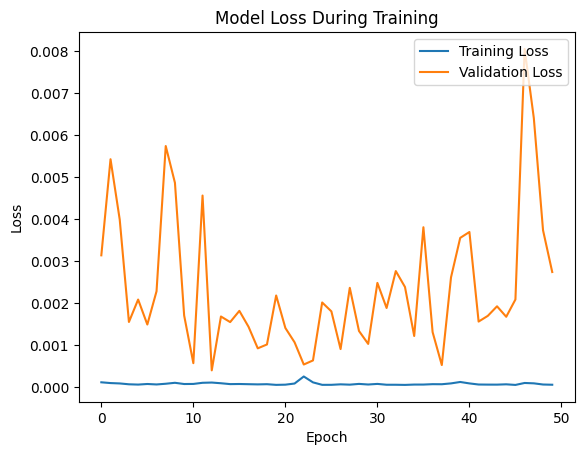

In [93]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [94]:
# Predictions on the test set
predictions = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [95]:
# Reverse scaling of predictions
predictions = scaler.inverse_transform(predictions)

In [96]:
# Reverse scaling of true test values
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

## Plot predicted vs actual values

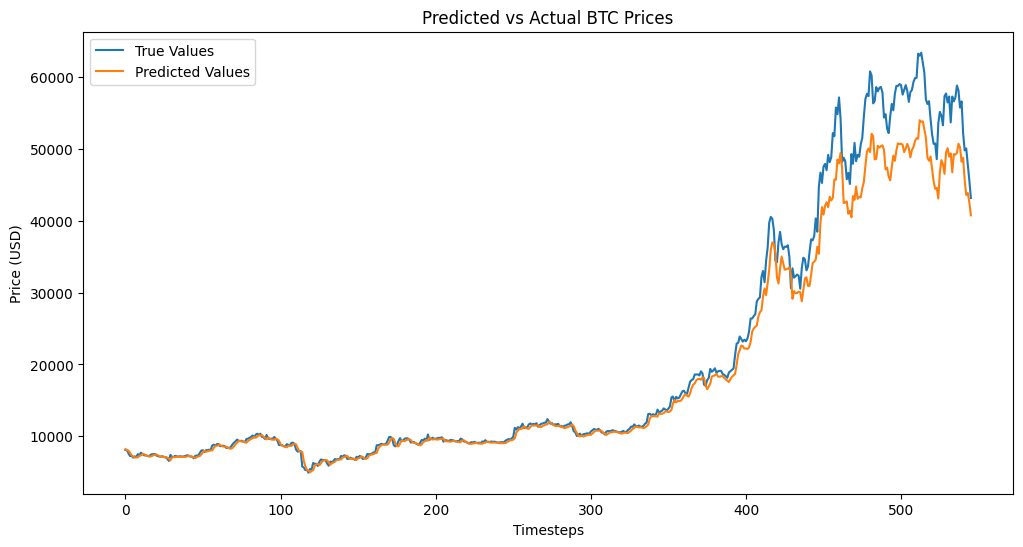

In [97]:
# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="True Values")
plt.plot(predictions, label="Predicted Values")
plt.title("Predicted vs Actual BTC Prices")
plt.xlabel("Timesteps")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

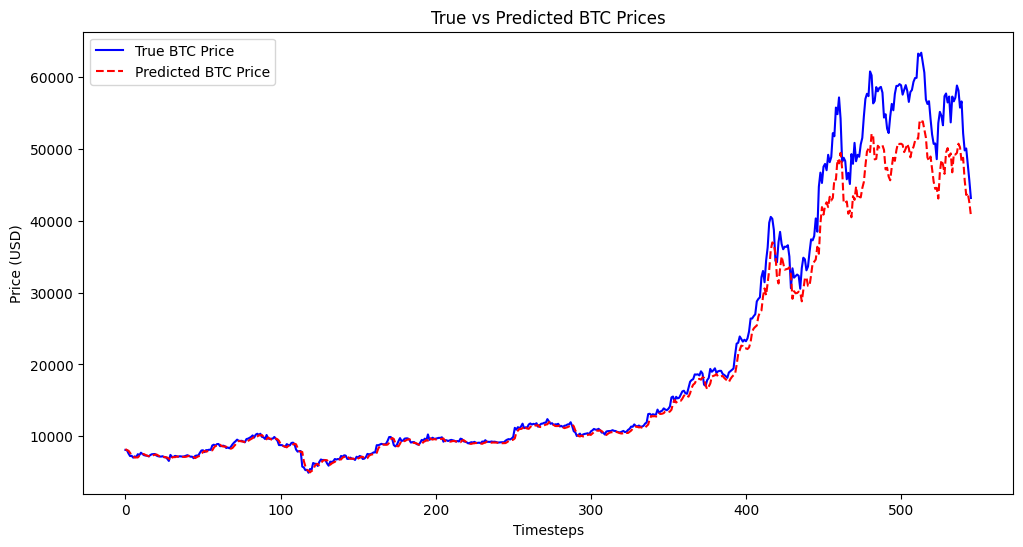

In [98]:
# Plot the actual vs predicted values over time
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="True BTC Price", c='blue')
plt.plot(predictions, label="Predicted BTC Price", c='red', linestyle="--")
plt.title("True vs Predicted BTC Prices")
plt.xlabel("Timesteps")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


# performance metrics

In [100]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test_rescaled, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R² score
r2 = r2_score(y_test_rescaled, predictions)
print(f"R-squared (R²) Score: {r2}")


Root Mean Squared Error (RMSE): 3309.218108036123
Mean Absolute Error (MAE): 1777.6031314438799
R-squared (R²) Score: 0.9647173796749015


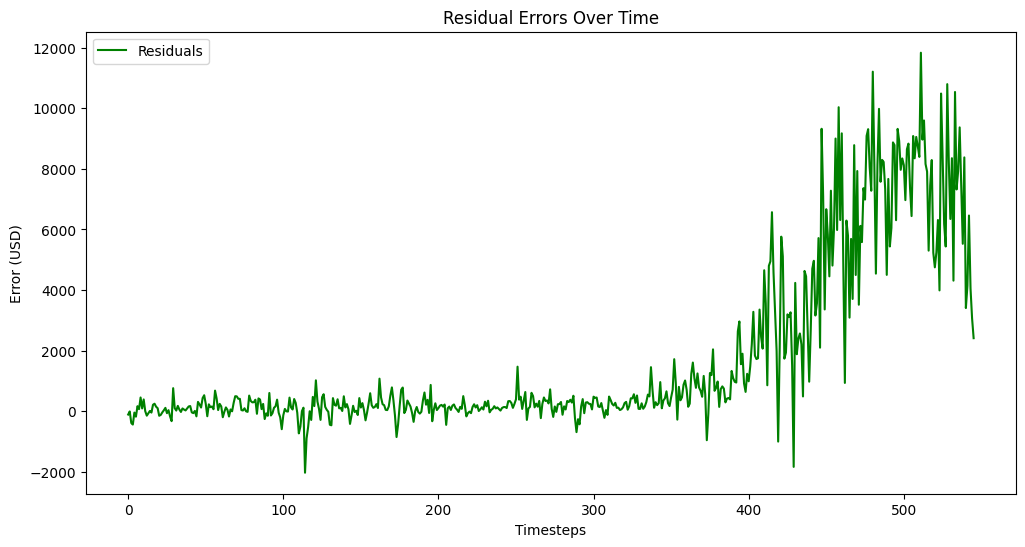

In [101]:
# Calculate residuals
residuals = y_test_rescaled - predictions

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals", c='green')
plt.title("Residual Errors Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Error (USD)")
plt.legend()
plt.show()


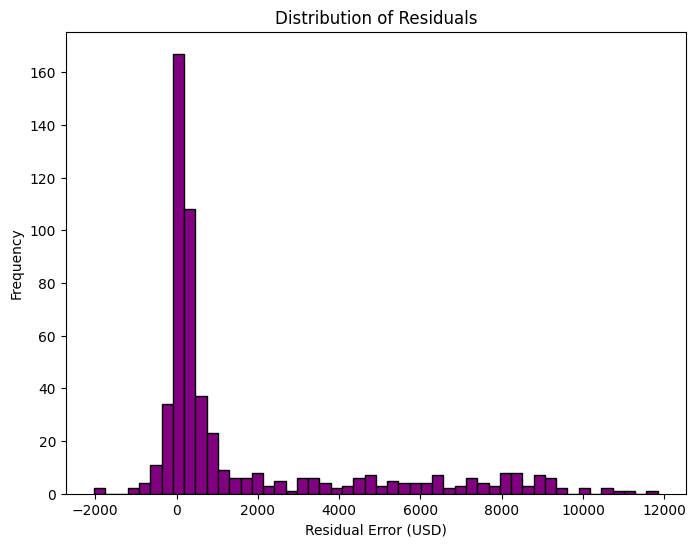

In [102]:
# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, color='purple', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residual Error (USD)")
plt.ylabel("Frequency")
plt.show()


# Conclusion

Working on the task of forecasting Bitcoin prices using an LSTM model has been an enlightening and rewarding experience. This project allowed me to delve into the intricacies of time series analysis and the application of deep learning techniques to real-world financial data.

#### Experience and Insights Gained:
- **Data Handling**: I gained valuable experience in preprocessing time series data, which included normalization, sequence generation, and the creation of training and testing datasets. Understanding the importance of each preprocessing step was crucial in ensuring the model's effectiveness.
- **Model Training**: Training the LSTM model highlighted the significance of hyperparameter tuning and the impact of architectural choices on performance. Experimenting with different configurations allowed me to appreciate the nuances involved in building a robust forecasting model.
- **Evaluation**: Analyzing model performance through metrics and visualizations provided insights into the strengths and weaknesses of the predictions. It underscored the importance of not just achieving good accuracy but also understanding the model's behavior over time.

#### Challenges Faced:
- **Market Volatility**: One of the primary challenges in forecasting Bitcoin prices is the inherent volatility of the cryptocurrency market. Sudden price spikes or drops can significantly affect predictions, making it difficult for models to generalize effectively.
- **Data Quality**: Ensuring high-quality, consistent data was a continuous challenge. Data anomalies or missing values could lead to misleading predictions, necessitating thorough cleaning and validation processes.
- **Overfitting**: There was a risk of overfitting the model to historical data, particularly in a complex model like LSTM. Striking the right balance between model complexity and generalization was an ongoing concern.

#### Potential of BTC Price Forecasting:
- **Investment Strategies**: Accurate forecasting of Bitcoin prices has immense potential for informing investment strategies. Traders and investors can make more informed decisions based on predictive insights, potentially maximizing returns.
- **Market Analysis**: Enhanced forecasting models could aid in understanding market trends and cycles, contributing to broader economic analyses and forecasting efforts within the cryptocurrency domain.
- **Continuous Improvement**: The field of time series forecasting, especially in volatile markets like cryptocurrency, is ripe for innovation. Incorporating more advanced techniques, such as ensemble methods or hybrid models that combine LSTMs with other algorithms, could yield even better results.

In summary, this forecasting task not only enhanced my technical skills but also deepened my understanding of the complexities involved in predicting financial markets. The challenges faced have underscored the importance of adaptability and continuous learning in the dynamic world of cryptocurrency.
